In [4]:
import random
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
)

2025-05-03 23:58:39.001240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746316719.043252   71838 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746316719.055282   71838 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746316719.121934   71838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746316719.121975   71838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746316719.121978   71838 computation_placer.cc:177] computation placer alr

In [5]:
checkpoint = "HuggingFaceTB/SmolLM2-135M"
N = 1000  # number of rows in training set
max_length = 256  # max length of input (in tokens)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:

print("Loading dataset...")
dataset = load_dataset("MBZUAI/LaMini-instruction", split="train")
dataset_length = len(dataset)
print(f"Dataset length: {dataset_length}")

# to reduce training time, we reduce the size of the dataset
# we simply pick N random rows to be our training dataset,
# N/4 random rows to be our test dataset
# there is no intersection in these two datasets
all_indices = random.sample(range(dataset_length), N + N // 4)
train_indices = all_indices[:N]
test_indices = all_indices[N:]

train_dataset = dataset.select(train_indices)
test_dataset = dataset.select(test_indices)

Loading dataset...
Dataset length: 2585615


In [4]:
# each instruction-response pair is combined and formatted into a single 'text' input for the LLM
def format_example(example):
    return {
        "text": f"Directive ==>>==>>\n{example['instruction']}\n\nResponse ==>>==>>\n{example['response']}"
    }

train_dataset = train_dataset.map(format_example)
test_dataset = test_dataset.map(format_example)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [5]:
# Print a sample in the dataset
# The last field - 'text' - contains the formatted input for our LLM
for i in train_dataset[0]:
    print('>>>',i, '\n', train_dataset[0][i], '\n\n')

>>> instruction 
 The Lord of the Rings is an epic high fantasy novel written by English author and scholar J.R.R. Tolkien. The story began as a sequel to Tolkien's 1937 fantasy novel The Hobbit, but eventually developed into a much larger work. Written in stages between 1937 and 1949, The Lord of the Rings is one of the best-selling novels ever written, with over 150 million copies sold.
Answer this question, making sure that the answer is supposed by the text: did lord of the rings come before the hobbit?

OPTIONS:
- no
- yes 


>>> response 
 According to the provided text, The Hobbit was written before The Lord of the Rings, so the answer is NO. 


>>> instruction_source 
 original_flan 


>>> text 
 Directive ==>>==>>
The Lord of the Rings is an epic high fantasy novel written by English author and scholar J.R.R. Tolkien. The story began as a sequel to Tolkien's 1937 fantasy novel The Hobbit, but eventually developed into a much larger work. Written in stages between 1937 and 1949

In [6]:
# Tokenizer: The padding token is the same as the EOS token
print("Tokenizing...")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token 

# The collation step is handled here, the text is truncated to a max token length of 256
# Any shorter samples are padded with EOS token to make them 256 tokens long
def tokenize(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )
    encoding["labels"] = encoding["input_ids"].copy()
    return encoding

tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)

tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Tokenizing...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [7]:
print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

Loading model...


In [ ]:
training_args = TrainingArguments(
    output_dir="./smol-finetuned",
    per_device_train_batch_size=2,
    num_train_epochs=1,
    logging_steps=50,
    eval_steps=50,
    eval_strategy="steps", # this ensures that evaulation/validation is done at each step (10 batches), instead of after every epoch
    save_strategy="no",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
)

print("Training...")
trainer.train()

print("Saving model...")
model.save_pretrained("./smol-finetuned")
tokenizer.save_pretrained("./smol-finetuned")
print("Done.")

/tmp/ipykernel_68528/2040495758.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training...


Step,Training Loss,Validation Loss
50,1.492400,0.846392
100,0.901300,0.823873
150,0.885600,0.811850
200,0.912400,0.801256
250,0.805200,0.796600
300,0.865700,0.792396
350,0.856200,0.788687
400,0.822200,0.786057
450,0.786000,0.783925
500,0.916800,0.783384


Saving model...
Done.


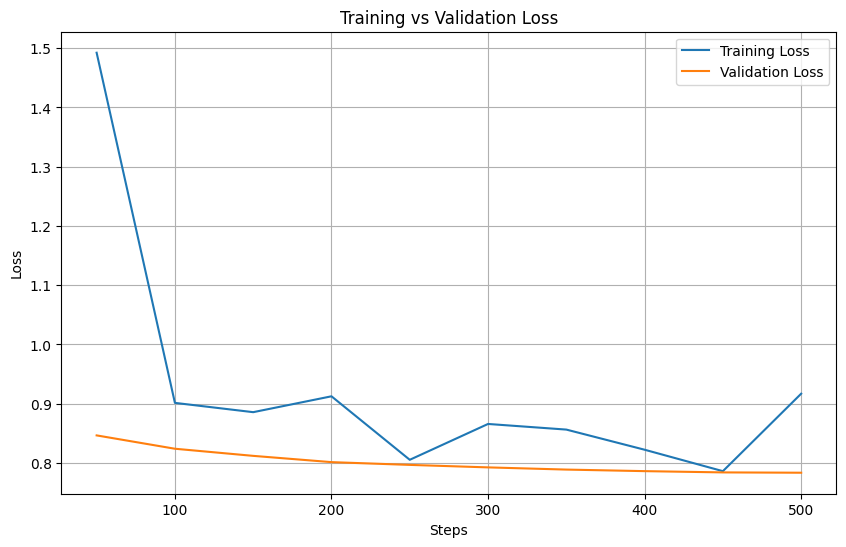

In [11]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history
train_steps, train_losses, val_losses = [], [], []

for entry in logs:
    if "loss" in entry and "step" in entry:
        train_steps.append(entry["step"])
        train_losses.append(entry["loss"])
    if "eval_loss" in entry and "step" in entry:
        val_losses.append(entry["eval_loss"])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label="Training Loss")
plt.plot(train_steps[:len(val_losses)], [i*1 for i in val_losses], label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def generate_response(instruction: str, model_path: str = "./smol-finetuned", max_length: int = 128, device: str = "cuda"):


    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
    # Format instruction using your custom template
    input_text = f"Directive ==>>==>>\n{instruction.strip()}\n\nResponse ==>>==>>"
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    
    # Generate response
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=max_length,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
        )

    # Decode and clean up
    full_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    response = full_output[len(input_text):].strip() if full_output.startswith(input_text) else full_output.strip()

    return response


In [35]:
reply = generate_response("Why does the sun shine?")
print("Response:", reply)


Response: Directive ==>>==>>
Why does the sun shine?

Response ==>>==>>
The sun shines because it is a star, and because it is a star that is shining.
